## Load data

In [1]:
from load_data import load_main_data

# main dataset
df, num_features, cat_features = load_main_data()
df.head(3)

Cat features distributions
|    | Name             | Vals                                           | Counts          |
|---:|:-----------------|:-----------------------------------------------|:----------------|
|  0 | mainroad         | ['no', 'yes']                                  | [76, 456]       |
|  1 | guestroom        | ['no', 'yes']                                  | [437, 95]       |
|  2 | basement         | ['no', 'yes']                                  | [346, 186]      |
|  3 | hotwaterheating  | ['no', 'yes']                                  | [507, 25]       |
|  4 | airconditioning  | ['no', 'yes']                                  | [364, 168]      |
|  5 | prefarea         | ['no', 'yes']                                  | [406, 126]      |
|  6 | furnishingstatus | ['furnished', 'semi-furnished', 'unfurnished'] | [137, 223, 172] |

Cat features converted to numerical (avoid overfitting on rare samples)
|    | Name      | Vals               | Counts                 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,logarea
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,8.911934
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,9.100526
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,9.206332


#### Train-test split

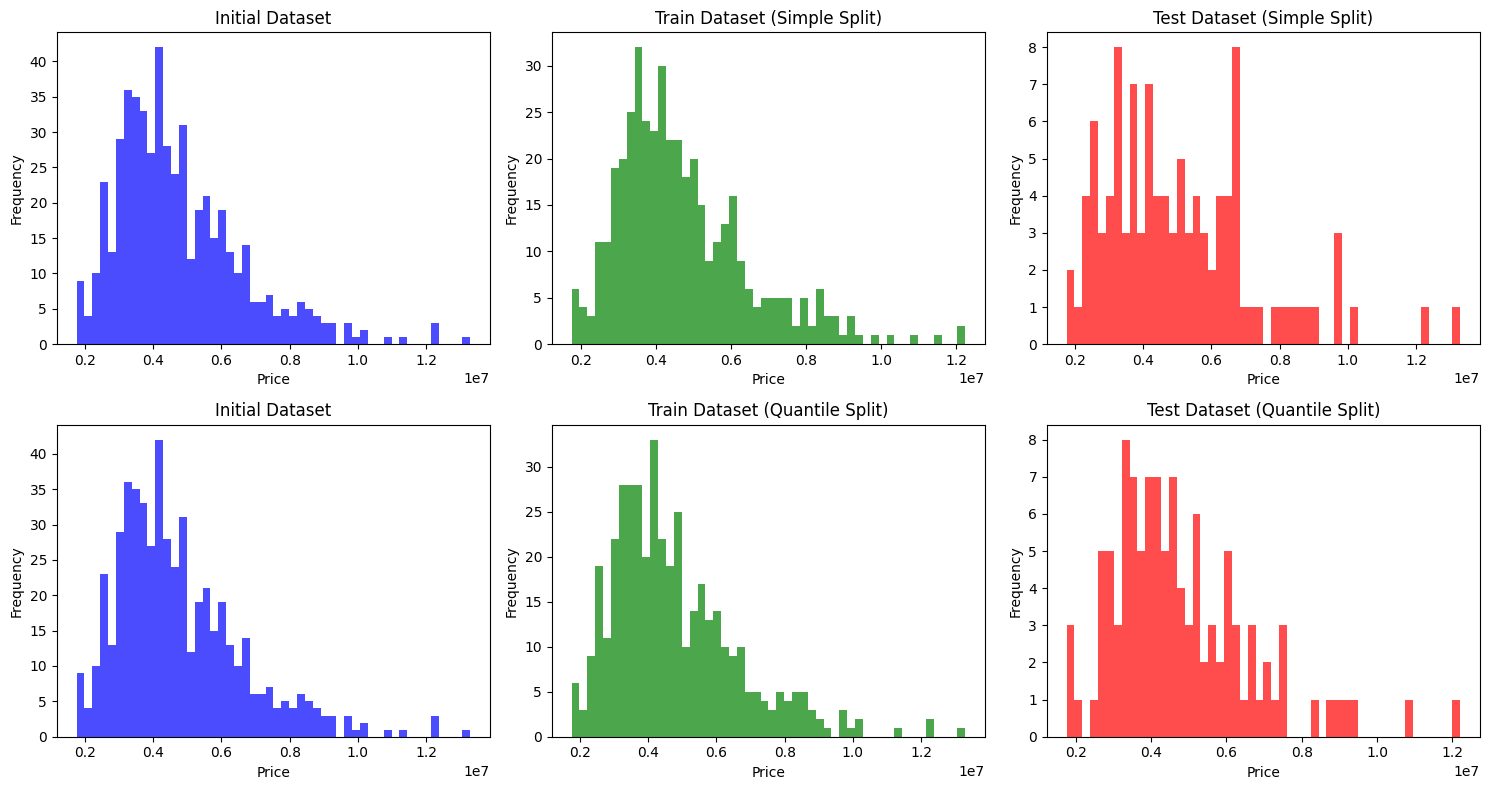

Train: (422, 14). Test: (110, 14)


In [2]:
from utils import split_results

df, df_test = split_results(df, test_size=0.2, num_quantiles=10, seed=42)
print(f"Train: {df.shape}. Test: {df_test.shape}")

### Additional dataset

In [3]:
import pandas as pd

from load_data import load_add_data

# additional dataset
df_add, num_features_add, cat_features_add = load_add_data(
    df, num_features, cat_features
)
assert len(pd.merge(df_add, df_test, on=("price", "area"))) == 0

df_add.head(3)

Find duplicates. Dropping them...
Numerical features before removing extra values
|    | Name      | Vals                                       | Counts                                                     |
|---:|:----------|:-------------------------------------------|:-----------------------------------------------------------|
|  0 | bedrooms  | [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33] | [13, 194, 2737, 9730, 6849, 1586, 265, 38, 13, 6, 3, 1, 1] |
|  1 | bathrooms | [0, 1, 2, 3, 4, 5, 6, 7, 8]                | [85, 8254, 10481, 2217, 335, 48, 12, 2, 2]                 |
|  2 | stories   | [1, 2, 3]                                  | [12447, 8370, 619]                                         |

Final numerical features
|    | Name      | Vals               | Counts                             |
|---:|:----------|:-------------------|:-----------------------------------|
|  0 | bedrooms  | [1, 2, 3, 4, 5, 6] | [164, 2709, 9714, 6828, 1561, 252] |
|  1 | bathrooms | [1, 2, 3, 4]     

,bedrooms,bathrooms,area,stories,price,logarea
0,2,1,5650,1,231300,8
1,3,2,7242,2,538000,8
2,2,1,10000,1,180000,9


#### Filling missing features with simple models

In [4]:
from utils import preprocess_data
from load_data import fill_features

df_pre = preprocess_data(df, ["price"] + num_features_add, cat_features_add)
df_add_pre = preprocess_data(df_add, ["price"] + num_features_add, cat_features_add)

df_add = fill_features(
    df, df_pre, df_add, df_add_pre,
    list(set(cat_features) - set(cat_features_add))
)
df_add = fill_features(
    df, df_pre, df_add, df_add_pre,
    list(set(num_features) - set(num_features_add)), is_cat=False
)

print(f"Add df: {df_add.shape}")
df_add.head(3)

Add df: (21228, 14)


,bedrooms,bathrooms,area,stories,price,logarea,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus,mainroad,guestroom,parking
0,2,1,5650,1,231300,8,no,no,no,no,unfurnished,no,no,0
1,3,2,7242,2,538000,8,no,no,no,no,unfurnished,no,no,0
2,2,1,10000,1,180000,9,no,no,no,no,unfurnished,yes,no,0


### Synthetic data

In [ ]:
from load_data import generate_synt

df_synt = generate_synt(df, num_features, cat_features, num_samples=5000, tgt_name='price')
df_synt.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,logarea
0,5219160,3725.594731,2.520902,1.355955,2.972094,yes,no,yes,no,no,1.764697,no,unfurnished,8.554596
1,3572538,3126.642377,2.590647,0.833465,1.440037,yes,no,no,no,no,1.115012,no,furnished,8.320145
2,3951769,5472.581651,2.867418,1.945281,1.699089,yes,no,no,no,no,0.065201,no,semi-furnished,7.773275


## Metrics


In [6]:
import numpy as np

from utils import calc_metrics

df_pre = preprocess_data(df, num_features, cat_features)
mean_pred = np.ones_like(df['price']) * df['price'].mean()

print("Train metrics:", calc_metrics(df['price'], mean_pred))
print("Val metrics:", calc_metrics(df_test['price'], np.ones_like(df_test['price']) * df['price'].mean()))

Train metrics: {'RelMSE': 0.19972004143078015, 'RelMAE': 0.3363604879110457, 'MSE': 3476565096398.812, 'MAE': 1432361.2015677993}
Val metrics: {'RelMSE': 0.21615184238201895, 'RelMAE': 0.34014442089783736, 'MSE': 3532664069433.221, 'MAE': 1432818.9164153377}


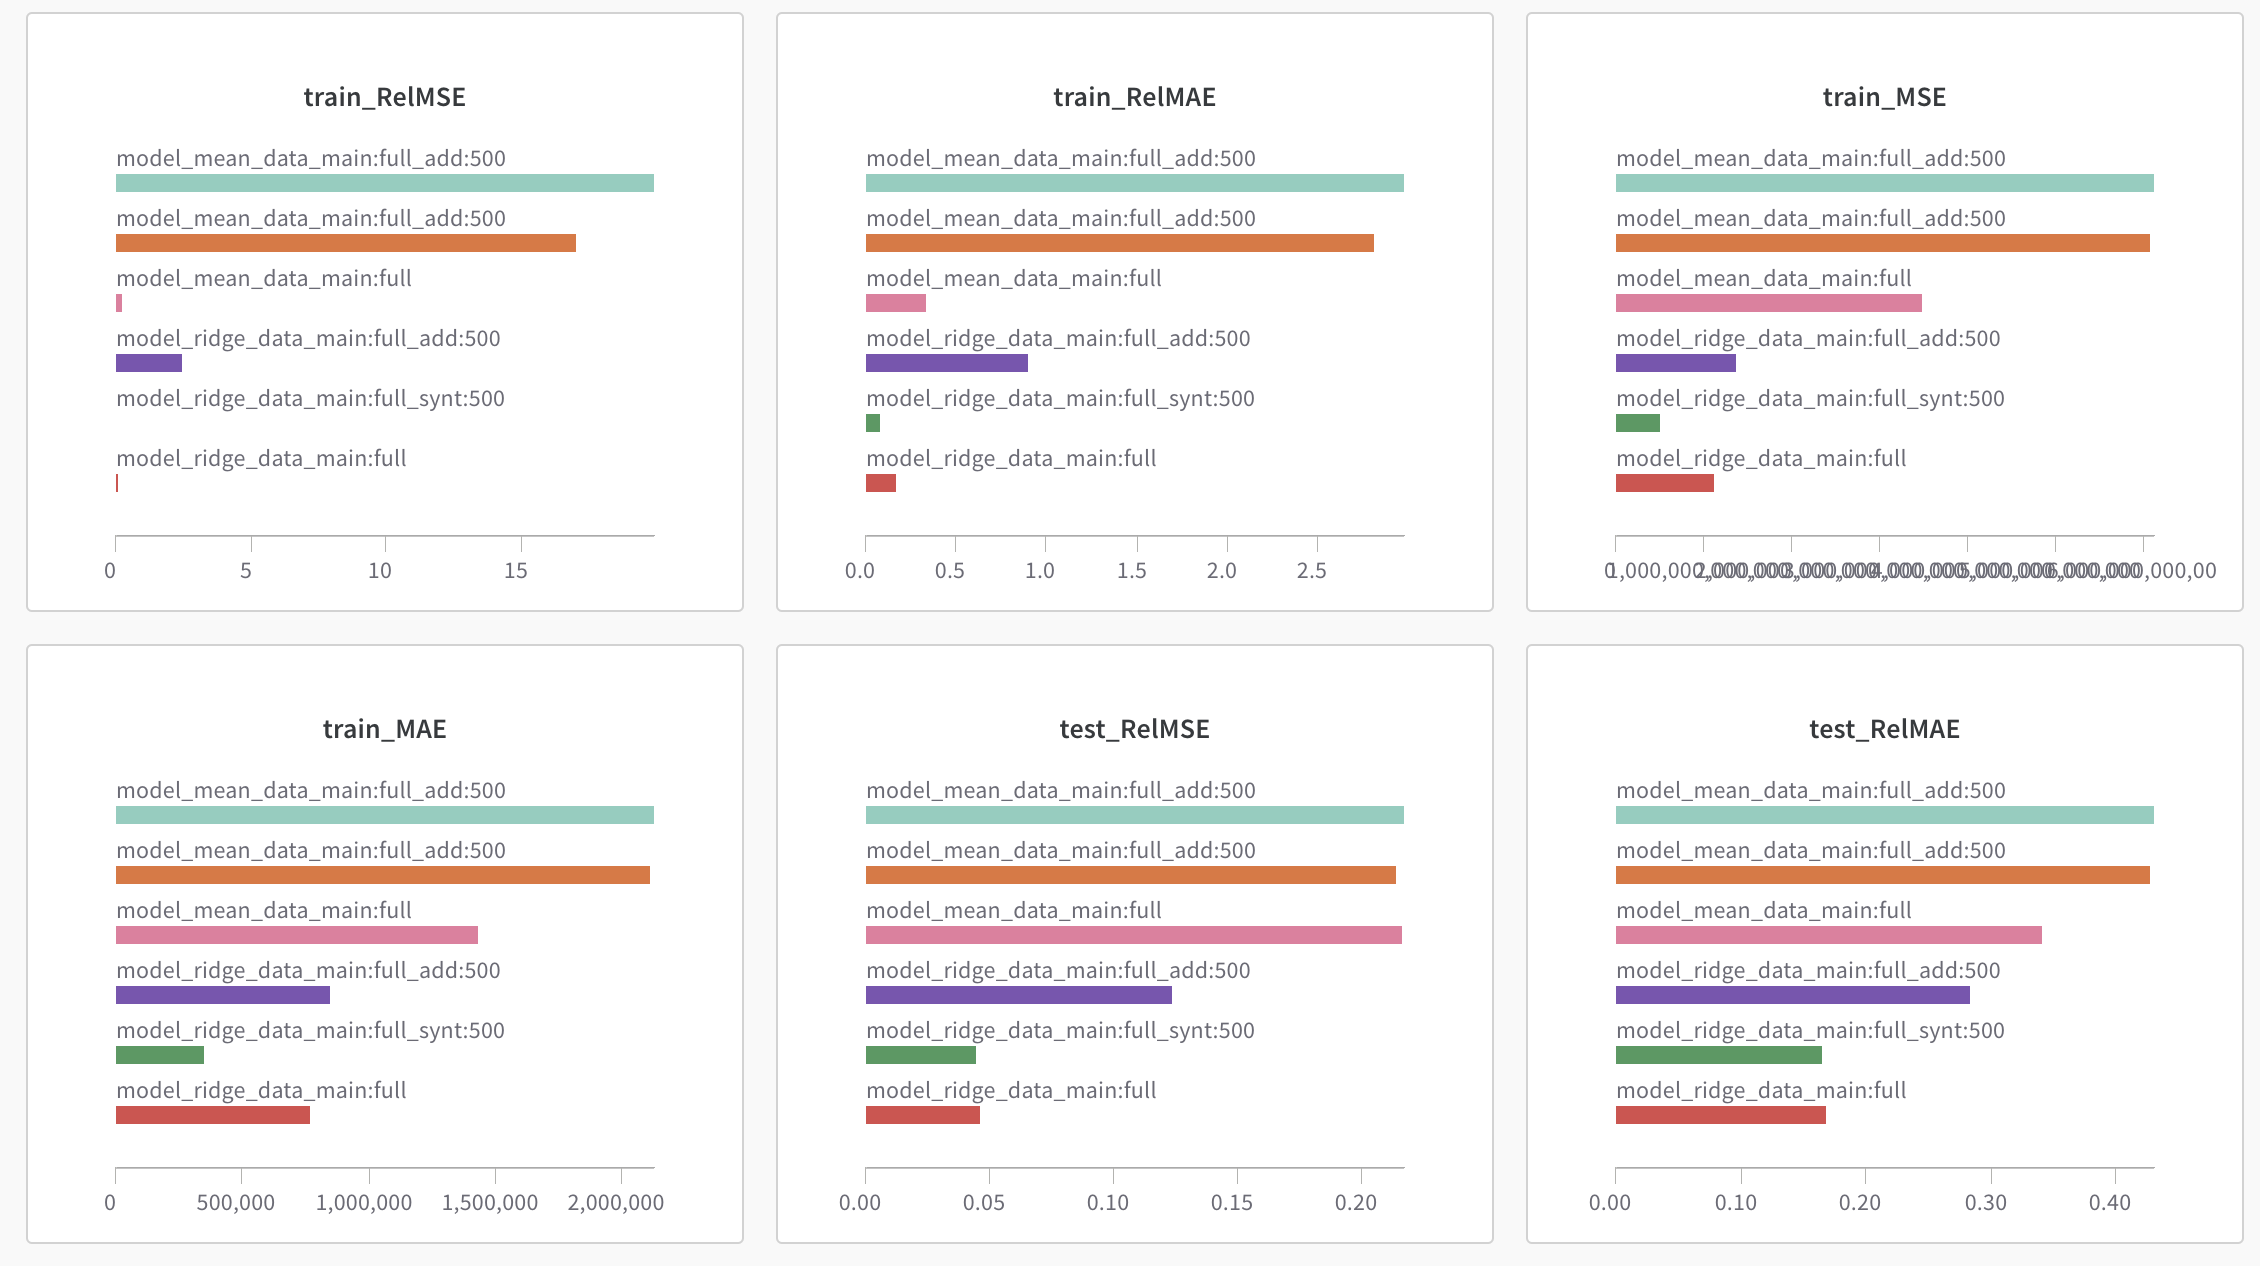

In [7]:
### baseline models with different amount of data
from IPython.display import Image
Image(filename='wandb_metrics.png')

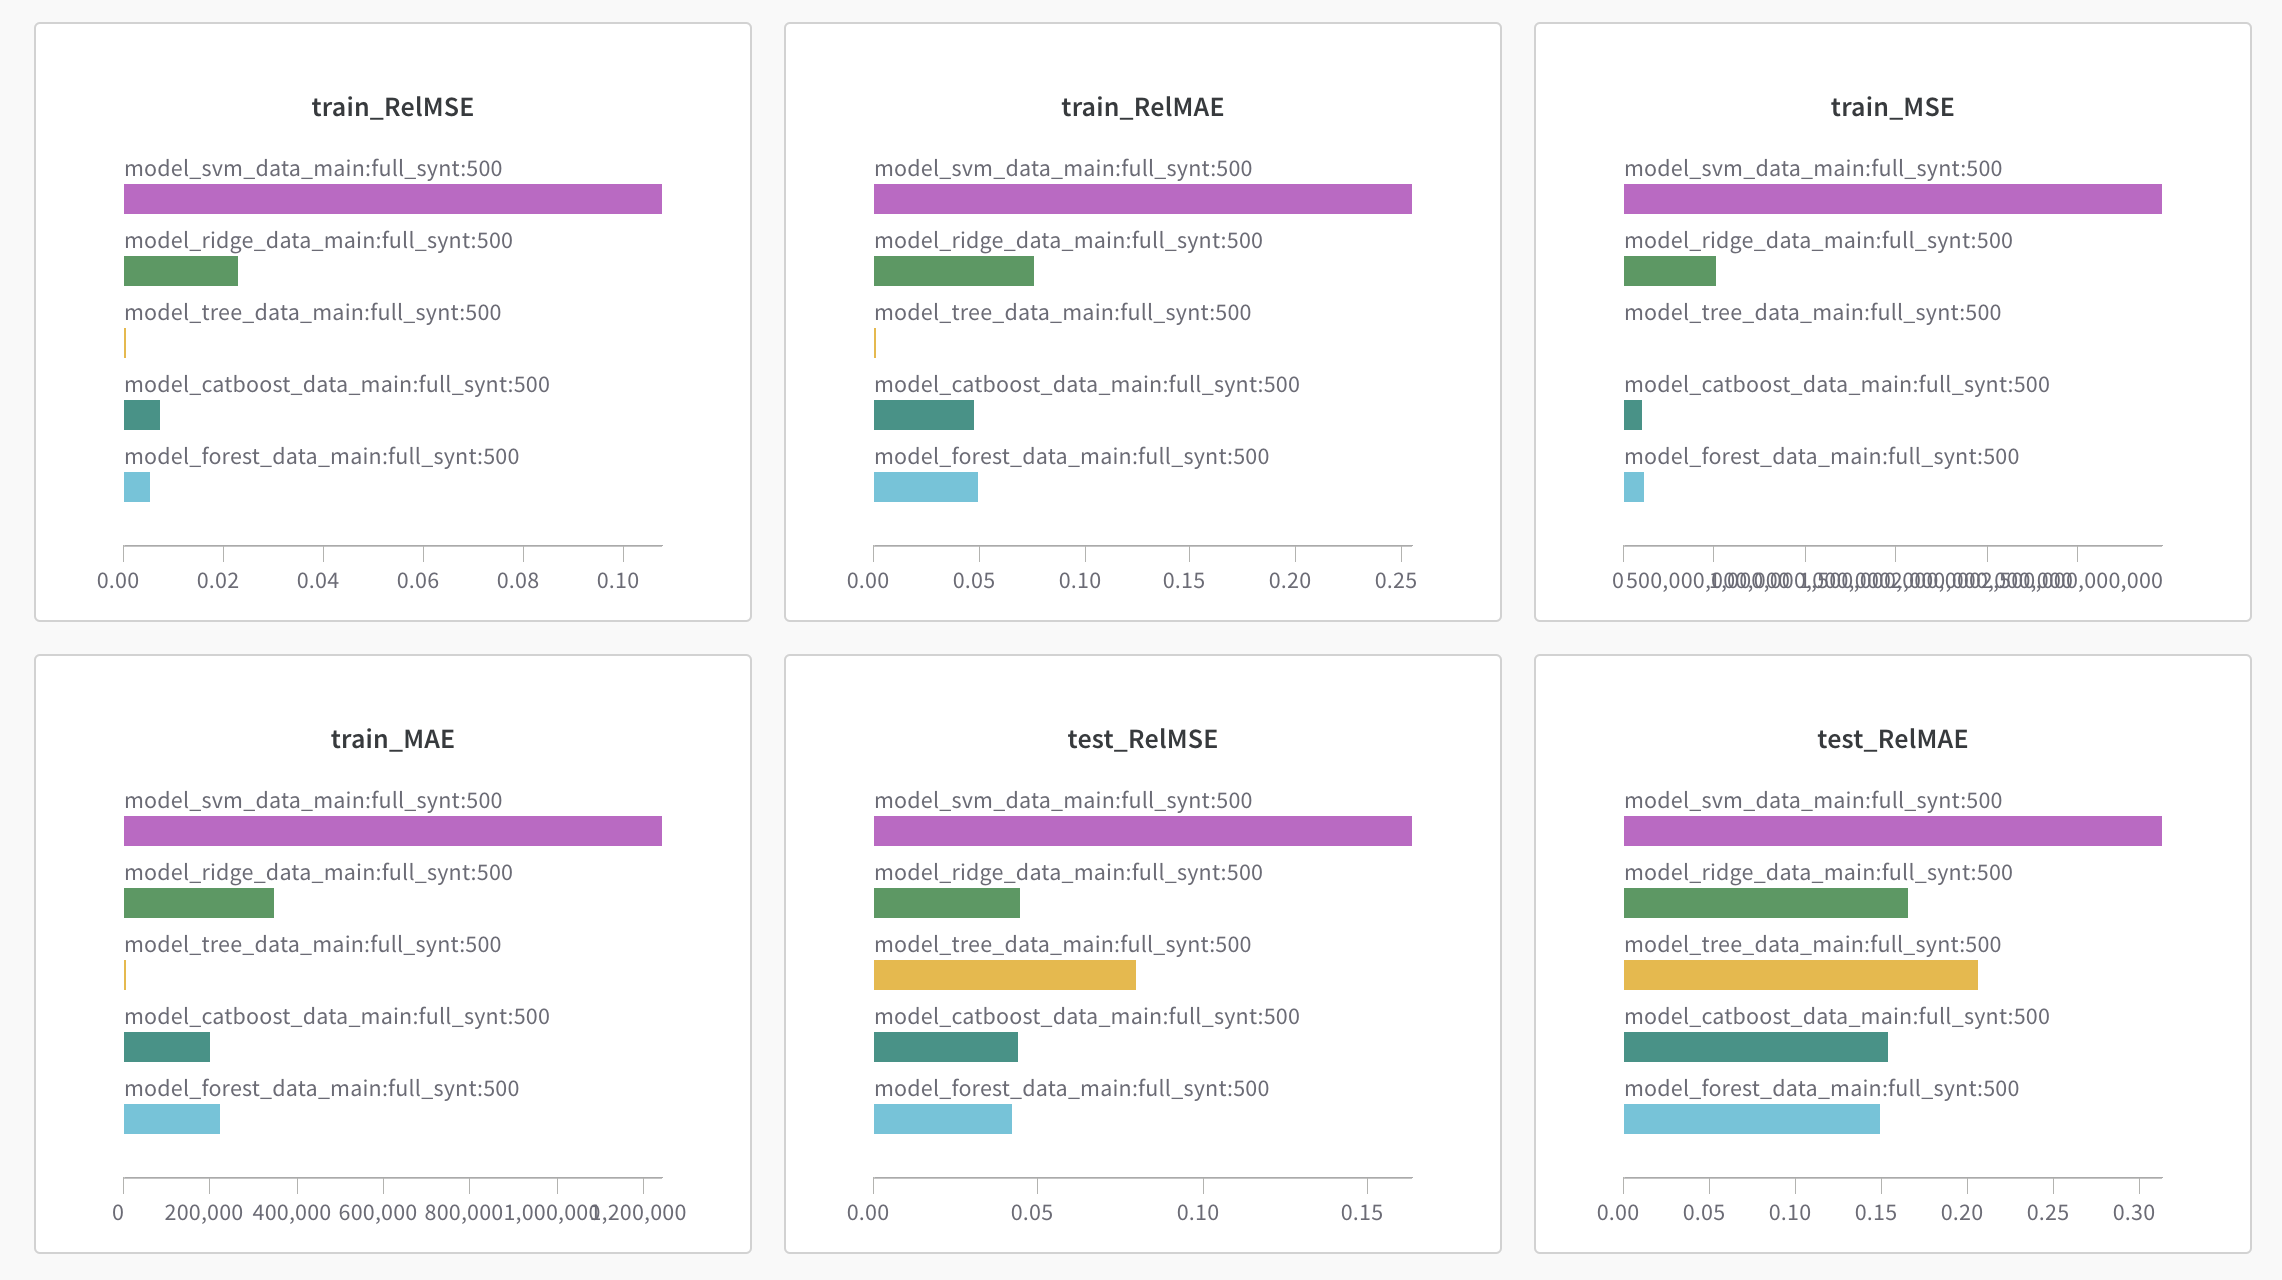

In [2]:
### promising (advanced) models - svm, tree, forest, catboost - compared to the baseline
from IPython.display import Image
Image(filename='img/models_better.png')

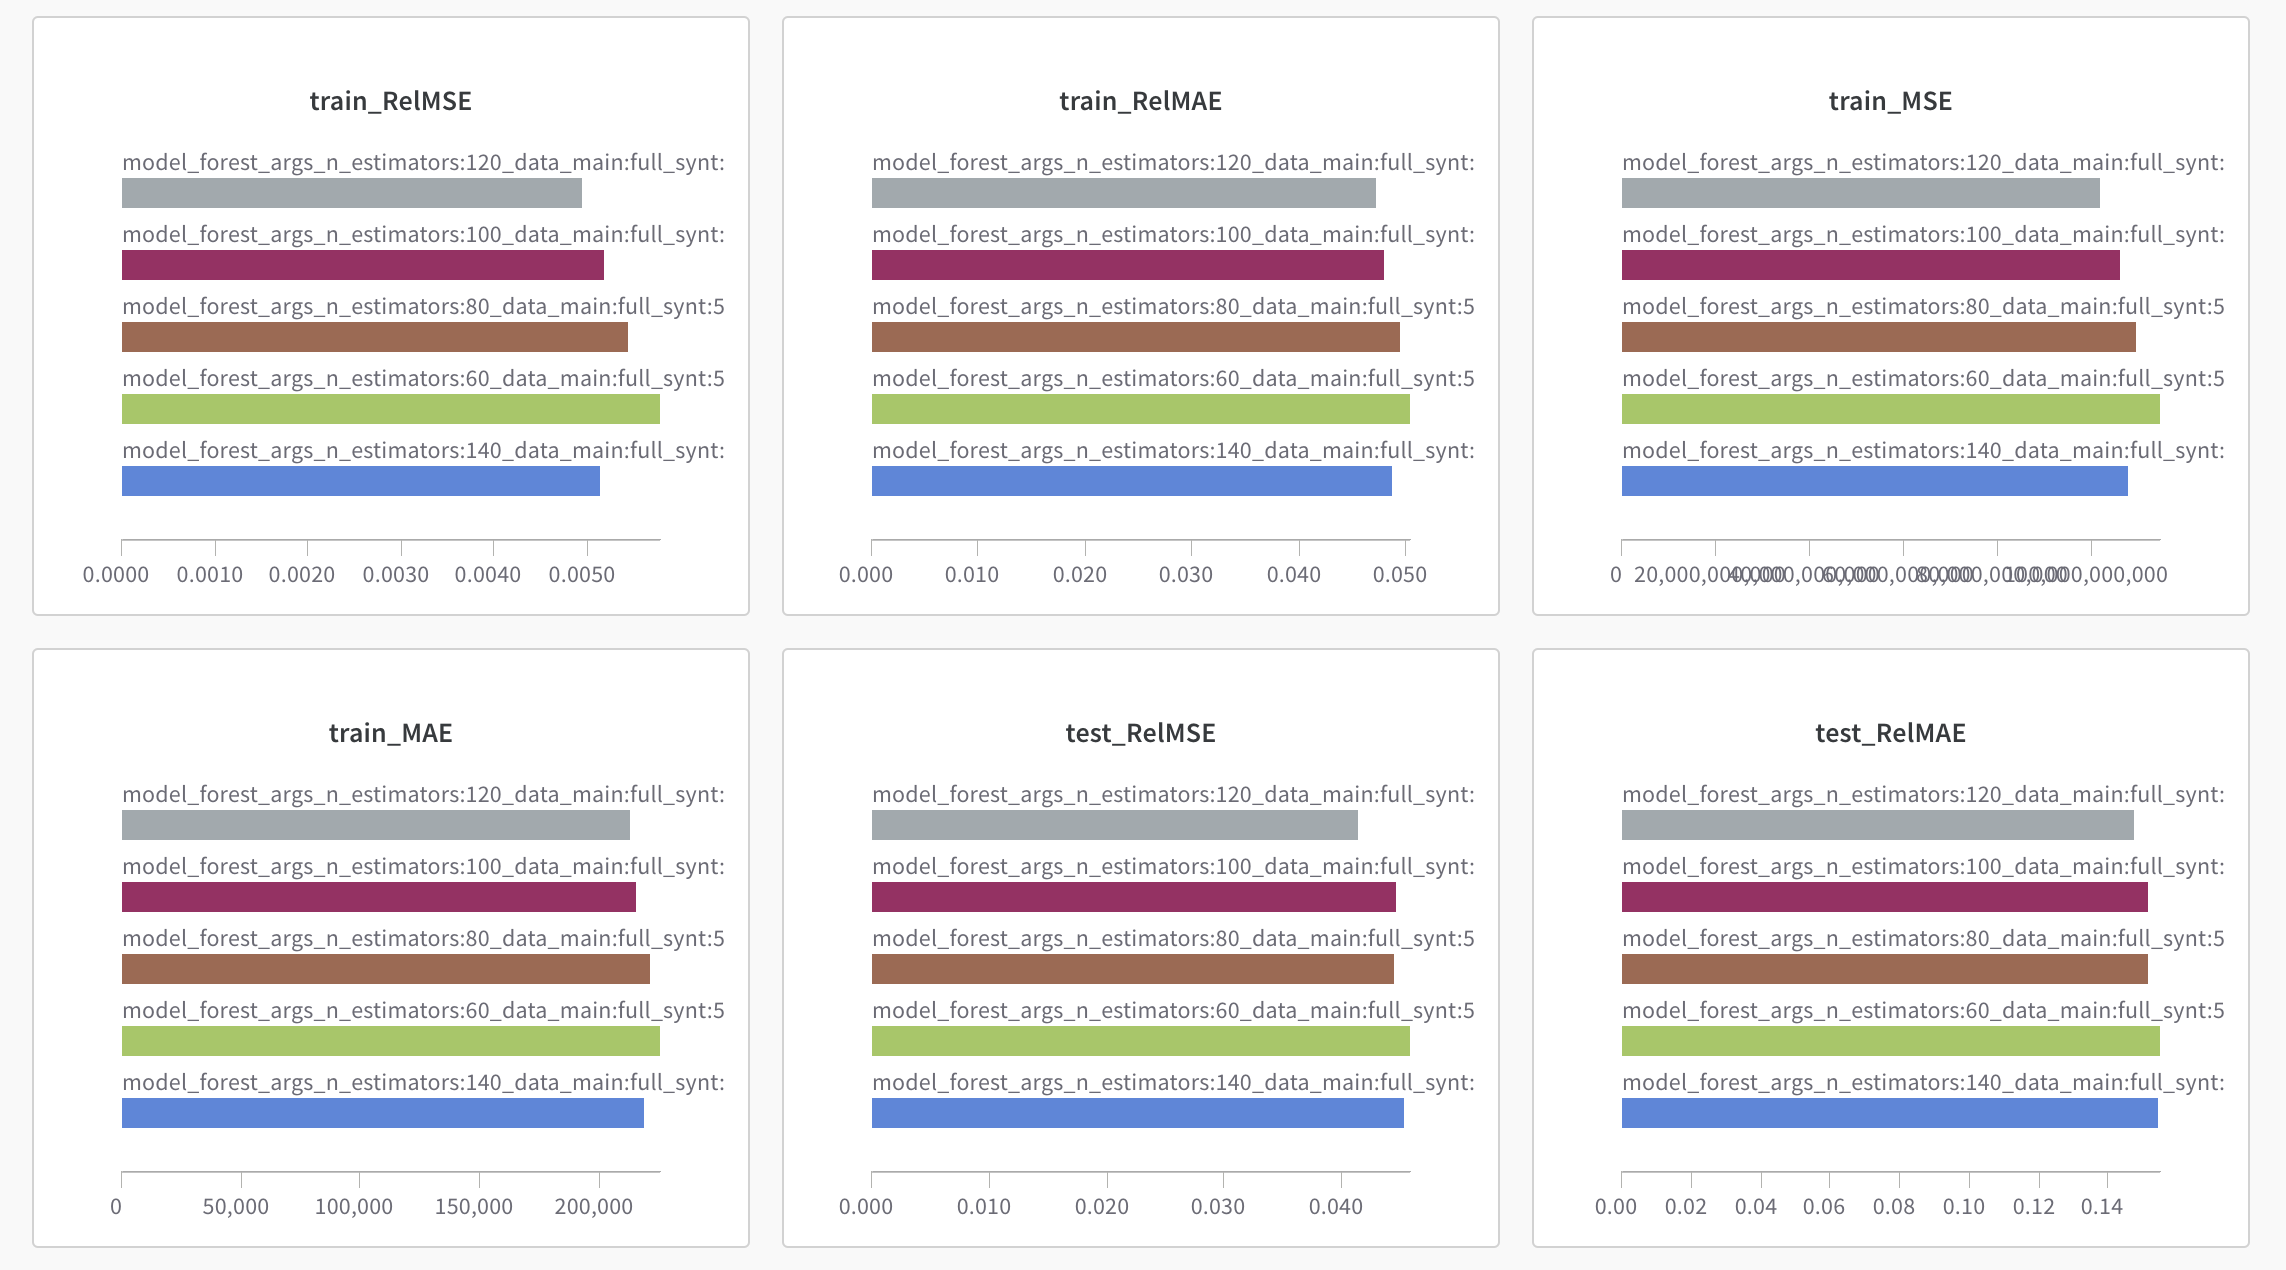

In [3]:
### example of logging 1D-GridSearch (searching for one parameter)
from IPython.display import Image
Image(filename='img/models_grid1d.png')

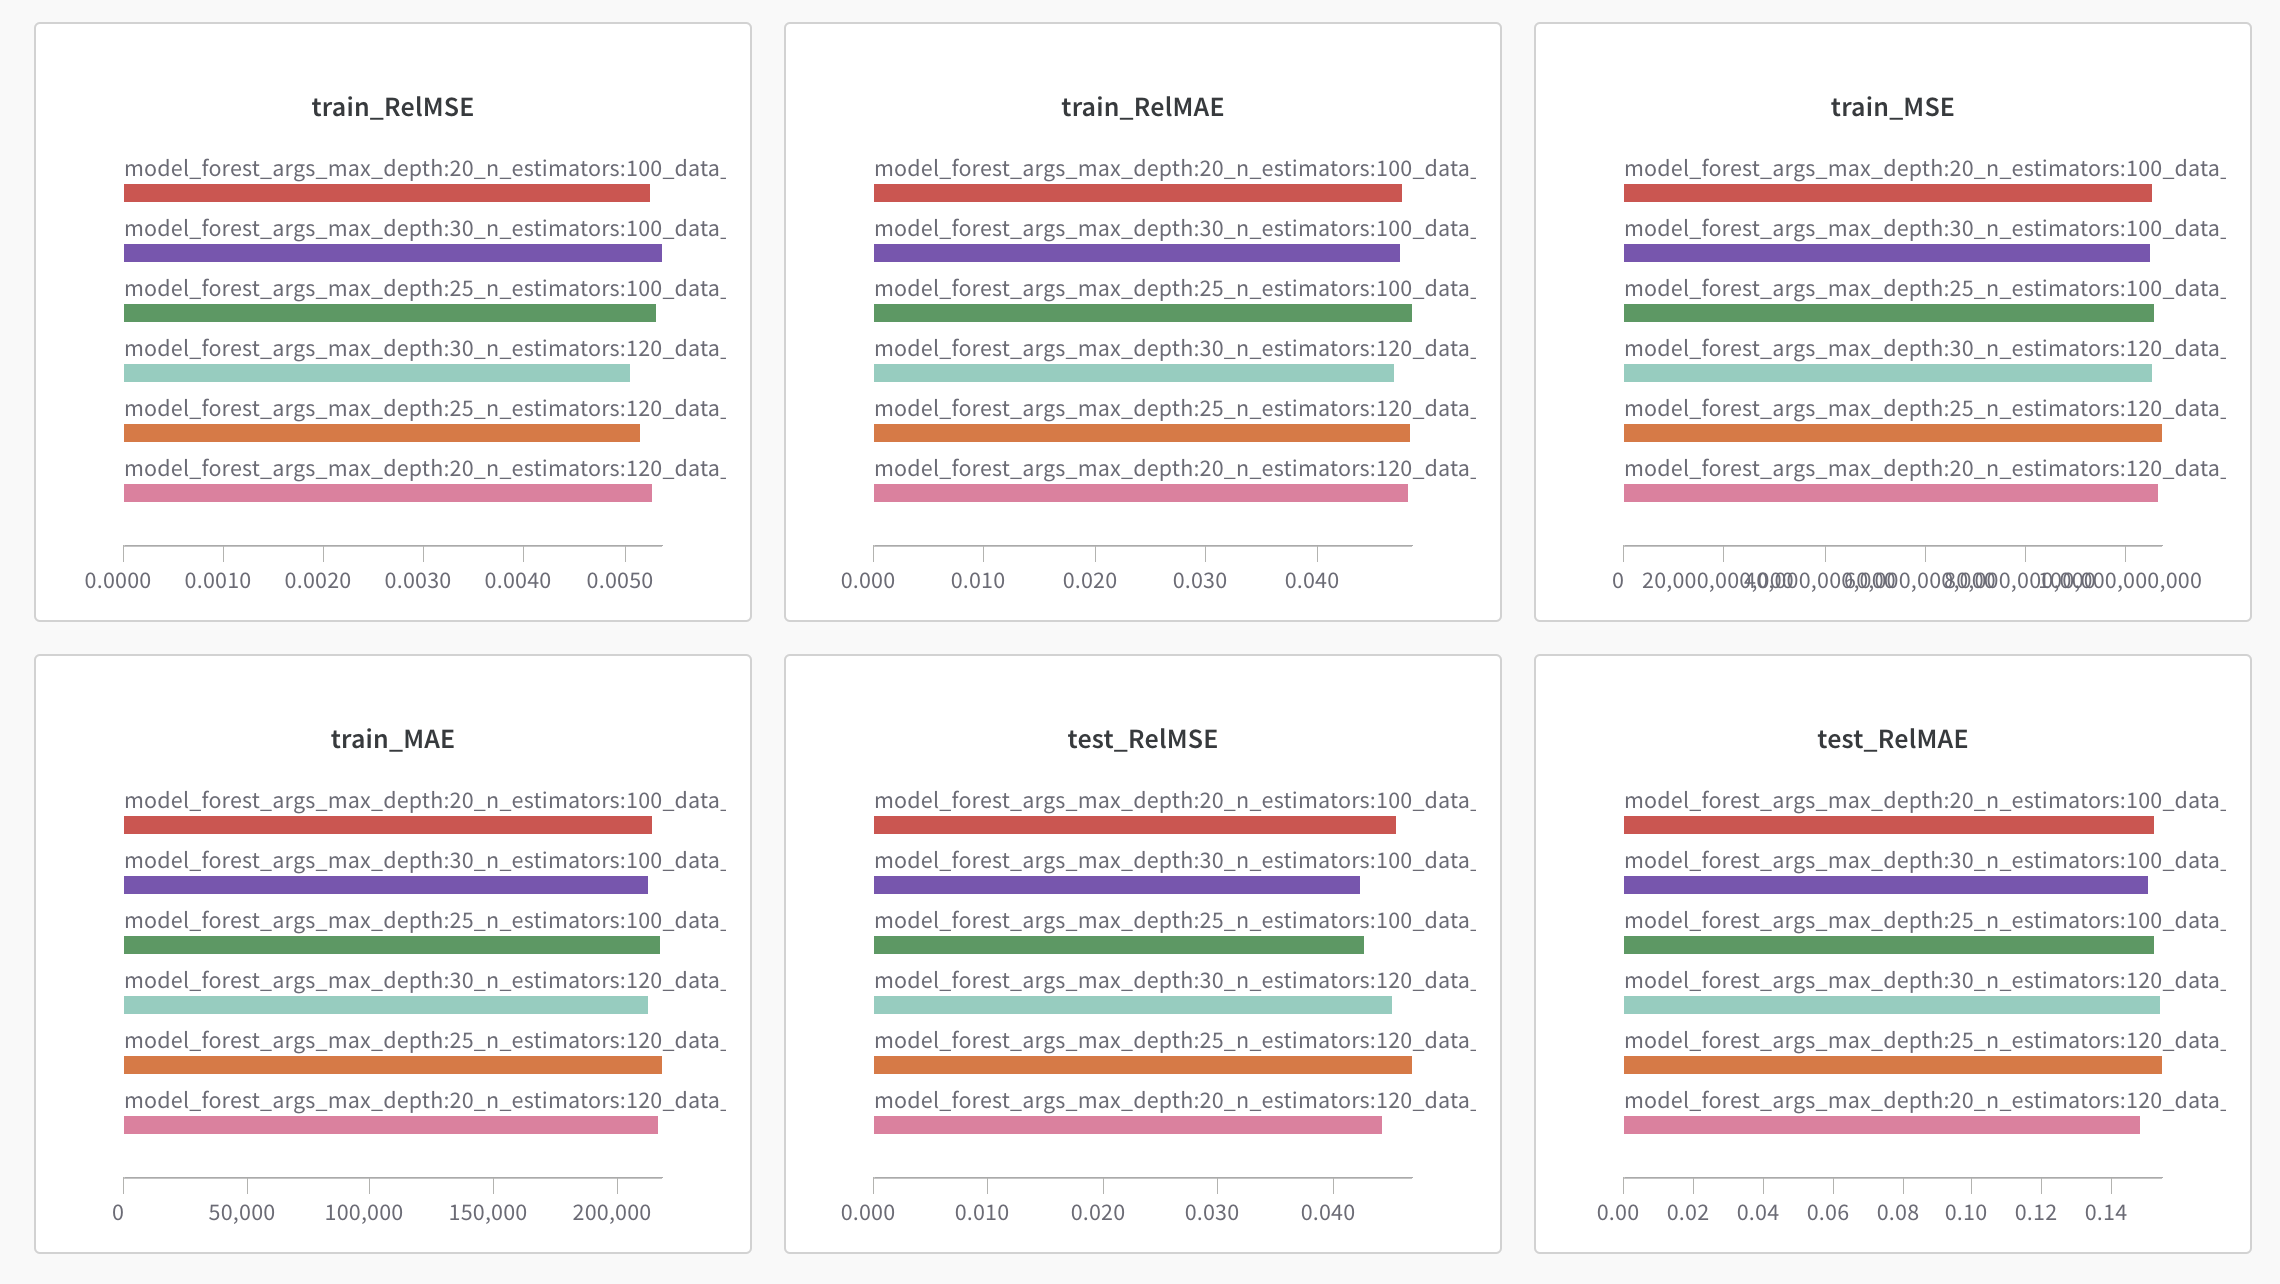

In [4]:
### example of logging 2D-GridSearch (searching for two parameters)
### Note: implementation allows using more params in GridSearch, however,
### such process will either cover small range of values, or work too slowly
### therefore, it is better to use optuna - see below
from IPython.display import Image
Image(filename='img/models_grid2d.png')

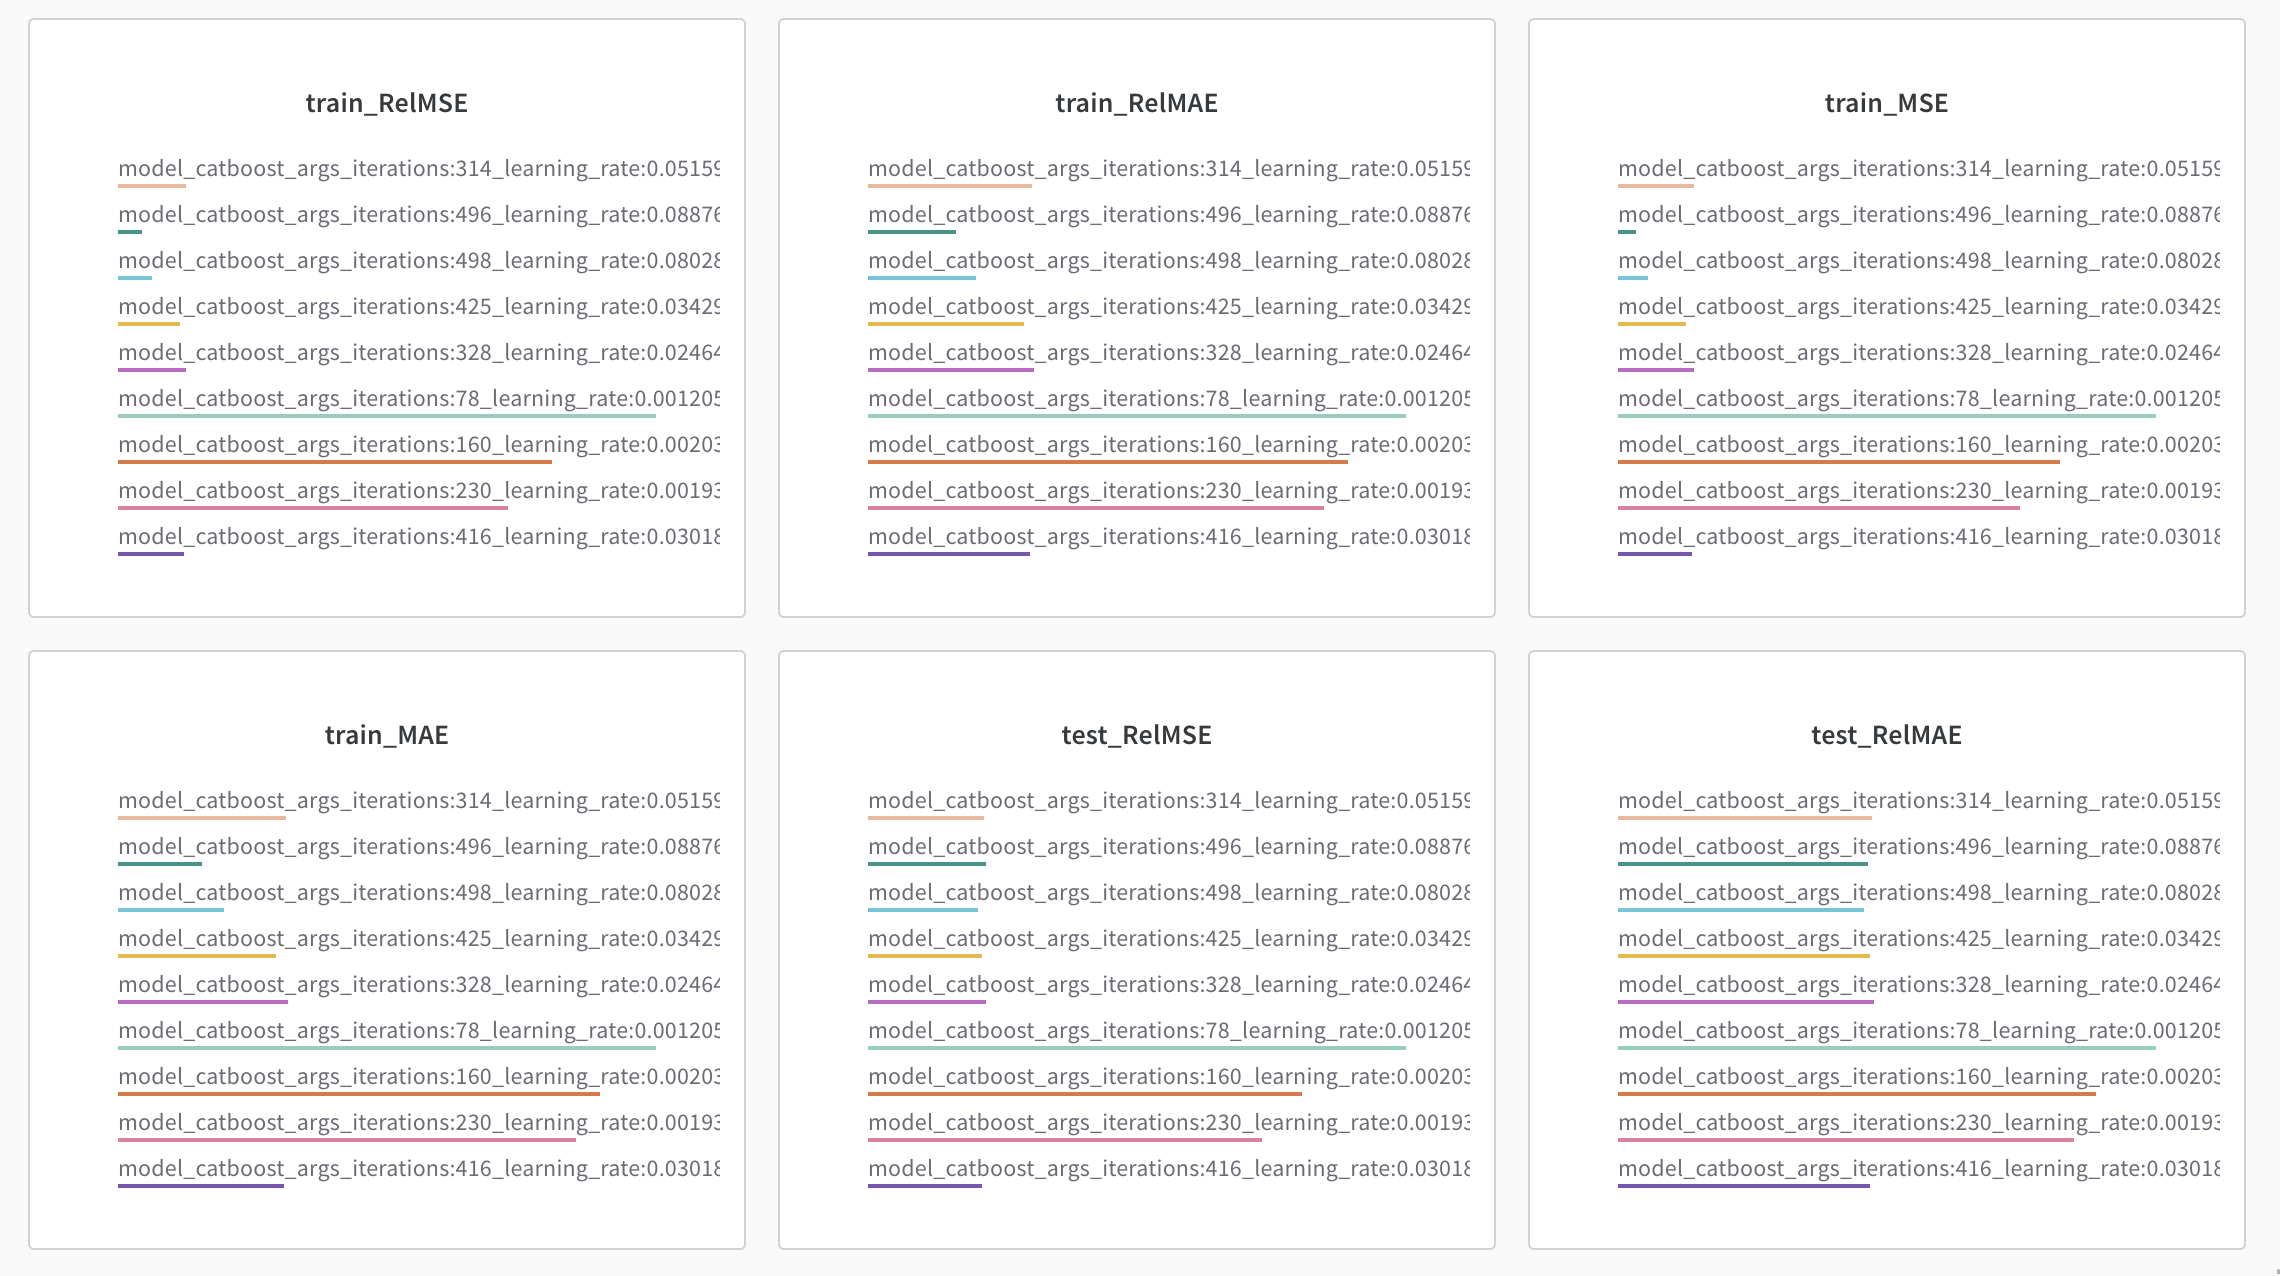

In [5]:
### example of logging optuna parameter search
### running code examples are available at `run.py`
from IPython.display import Image
Image(filename='img/models_optuna.png')